In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model

Base = automap_base()


# reflect the tables

Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found

Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table

Measure=Base.classes.measurement
Station=Base.classes.station

In [9]:
# Create our session (link) from Python to the DB

session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

In [11]:
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measure.date).order_by(Measure.date.desc()).first()[0]

last_date = dt.datetime.strptime(last_date, "%Y-%m-%d")

lastYr = last_date - dt.timedelta(days=365)

In [12]:

# Perform a query to retrieve the data and precipitation scores

precipt_data = session.query(Measure.date, Measure.prcp).filter(Measure.date >= lastYr).\
    filter(Measure.date <= "2017-08-23").all()



In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column

precipitation_df = pd.DataFrame(precipt_data).set_index('date')


In [14]:
# Sort the dataframe by date

precipitation_df=precipitation_df.sort_values(by='date').dropna()
precipitation_df.head()

precipitation_df=precipitation_df.rename(columns={'prcp':'precipitation'})


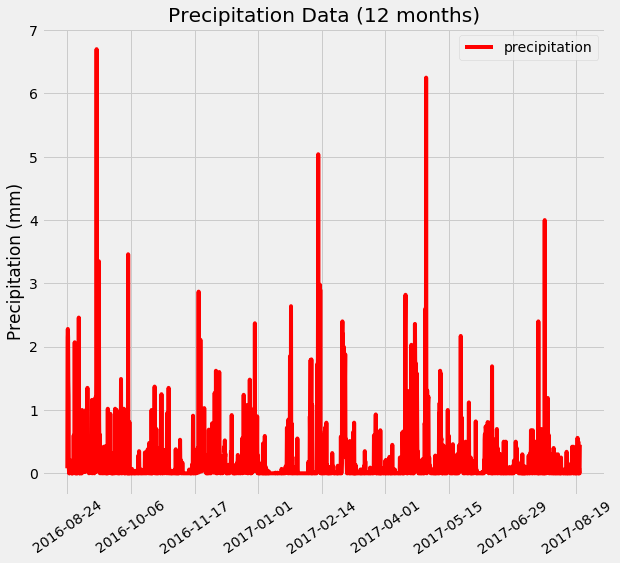

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data

precipitation_df.plot(color="red",rot=35, figsize=(9,8))
plt.title("Precipitation Data (12 months)")
plt.ylabel("Precipitation (mm)")
plt.xlabel("")
plt.savefig("images/Precipitation_Trnd")
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data

precipitation_df.describe().round(2)

,precipitation
count,2015.00
mean,0.18
std,0.46
min,0.00
25%,0.00
50%,0.02
75%,0.13
max,6.70


In [17]:
# Design a query to show how many stations are available in this dataset?

stations_count = session.query(Station).count()

print(f'There are {stations_count} stations in this query.')


There are 9 stations in this query.


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active_stations = (
    session.query(Measure.station, Station.name, func.count(Measure.id))
    .filter(Measure.station == Station.station)
    .group_by(Measure.station)
    .order_by(func.count(Measure.id).desc())
    .all()
)
print(f'The Most active stations are: {active_stations}')




The Most active stations are: [('USC00519281', 'WAIHEE 837.5, HI US', 2772), ('USC00519397', 'WAIKIKI 717.2, HI US', 2724), ('USC00513117', 'KANEOHE 838.1, HI US', 2709), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979), ('USC00517948', 'PEARL CITY, HI US', 1372), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]


In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

station_record = (
    session.query(
        func.min(Measure.tobs),
        func.max(Measure.tobs),
        func.avg(Measure.tobs),
    )
    .filter(Measure.station == active_stations[0][0])
    .all()
)

print(f"The Most active station is {active_stations[0][0]} - {active_stations[0][1]}:")
print(f"Lowest Temperature: {station_record[0][0]}F")
print(f"Highest Temperature: {station_record[0][1]}F")
print(f"Average Temperature: {station_record[0][2]}F")



The Most active station is USC00519281 - WAIHEE 837.5, HI US:
Lowest Temperature: 54.0F
Highest Temperature: 85.0F
Average Temperature: 71.66378066378067F


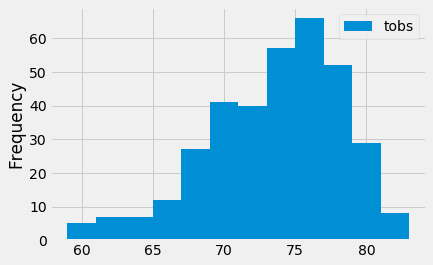

In [28]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

station_highest_obs = active_stations[0][0]

results = session.query(Measure.date, Measure.tobs).\
                        filter(Measure.date >= "2016-08-24").\
                        filter(Measure.date <= "2017-08-23").\
                        filter(Measure.station == station_highest_obs).all()

# convert to dataframe
results_df = pd.DataFrame(results)

# historgram 
results_df.plot.hist(bins=12)


## Bonus Challenge Assignment

In [30]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measure.tobs), func.avg(Measure.tobs), func.max(Measure.tobs)).\
        filter(Measure.date >= start_date).filter(Measure.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [31]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

print(calc_temps('2011-02-28', '2011-03-05'))
tmin, tavg, tmax = calc_temps('2011-02-28', '2011-03-05')[0]

[(61.0, 69.75510204081633, 75.0)]


/Users/DanLlamas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


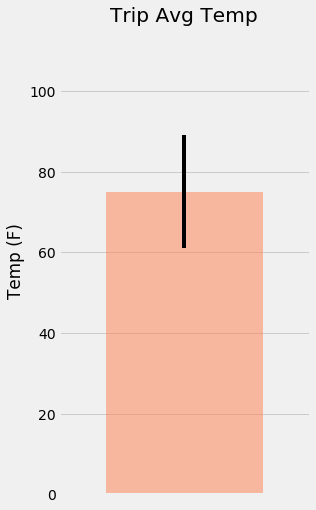

In [32]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots(figsize=plt.figaspect(2.))
yerr = tmax-tmin
ax.bar(1, tmax, yerr=yerr, alpha=0.5, color='coral', align="center")
ax.set(xticks=range(1), xticklabels="a", title="Trip Avg Temp", ylabel="Temp (F)")
ax.margins(.3, .3)
fig.show()


In [35]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


In [36]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

NameError: name 'Measurement' is not defined

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
